In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ee
import geopandas as gp
import rsfuncs as rs
import datetime

%load_ext autoreload
%autoreload 2

ee.Initialize()

In [17]:
years = range(2000, 2019)
months = range(1,13)
start = datetime.datetime(years[0], 1, 1)
end = datetime.datetime(years[-1]+1, 1, 1)
dt_idx = pd.date_range(start,end, freq='M')

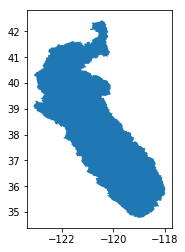

In [18]:
shp = gp.read_file("../shape/HU4_merged.shp")
shp.plot()

In [19]:
area = rs.gdf_to_ee_poly(shp)

In [20]:
data = rs.load_data()

In [21]:
dataset = data['gldas_swe']

In [22]:
ImageCollection = dataset[0]
var = dataset[1]
scaling_factor = dataset[2]

period_start = datetime.datetime(years[0], 1, 1)
start_date = period_start.strftime("%Y-%m-%d")
period_end = datetime.datetime(years[-1], 1, 1)
dt_idx = pd.date_range(period_start,period_end, freq='M')

ims = []
seq = ee.List.sequence(0, len(dt_idx))

In [23]:
seq.getInfo()

[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 64.0,
 65.0,
 66.0,
 67.0,
 68.0,
 69.0,
 70.0,
 71.0,
 72.0,
 73.0,
 74.0,
 75.0,
 76.0,
 77.0,
 78.0,
 79.0,
 80.0,
 81.0,
 82.0,
 83.0,
 84.0,
 85.0,
 86.0,
 87.0,
 88.0,
 89.0,
 90.0,
 91.0,
 92.0,
 93.0,
 94.0,
 95.0,
 96.0,
 97.0,
 98.0,
 99.0,
 100.0,
 101.0,
 102.0,
 103.0,
 104.0,
 105.0,
 106.0,
 107.0,
 108.0,
 109.0,
 110.0,
 111.0,
 112.0,
 113.0,
 114.0,
 115.0,
 116.0,
 117.0,
 118.0,
 119.0,
 120.0,
 121.0,
 122.0,
 123.0,
 124.0,
 125.0,
 126.0,
 127.0,
 128.0,
 129.0,
 130.0,
 131.0,
 132.0,
 133.0,
 134.0,
 135.0,
 136.0,
 137.0,
 138.0

In [106]:
ims = []

for i in seq.getInfo()[:1]:
    print(i)
    start = ee.Date(start_date).advance(i, 'month')
    end = start.advance(1, 'month');
    im = ee.ImageCollection(ImageCollection).select(var).filterDate(start, end).set('system:time_start', start.millis())
    result = im.getRegion(area,25000,"epsg:4326").getInfo()
    ims.append(result)



0.0


In [110]:
t = df_from_ee_object(ims[0])
t2 = array_from_df(t, var)

len(t2)

34

In [114]:
t2[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.], dtype=float32)

In [25]:
def df_from_ee_object(imcol):
    df = pd.DataFrame(imcol, columns = imcol[0])
    df = df[1:]
    return(df)

def array_from_df(df, variable):    
    # get data from df as arrays
    lons = np.array(df.longitude)
    lats = np.array(df.latitude)
    data = np.array(df[variable]) # Set var here 
                                              
    # get the unique coordinates
    uniqueLats = np.unique(lats)
    uniqueLons = np.unique(lons)

    # get number of columns and rows from coordinates
    ncols = len(uniqueLons)    
    nrows = len(uniqueLats)

    # determine pixelsizes
    ys = uniqueLats[1] - uniqueLats[0] 
    xs = uniqueLons[1] - uniqueLons[0]

    # create an array with dimensions of image
    arr = np.zeros([nrows, ncols], np.float32)

    # fill the array with values
    counter =0
    for y in range(0,len(arr),1):
        for x in range(0,len(arr[0]),1):
            if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
                counter+=1
                arr[len(uniqueLats)-1-y,x] = data[counter] # we start from lower left corner
    
    return arr


In [115]:
results = []

for i in ims:
    df = df_from_ee_object(i)

    images = []
    for i in df.id.unique():
        arr = array_from_df(df[df.id == i], var)
        arr[arr==0] = np.nan
        images.append(arr)
        
    results.append(images)
    

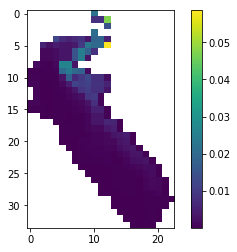

In [116]:
plt.imshow(results[0][100]*1.0E-12* 25000**2)
plt.colorbar()

In [119]:
len(results[0])

240

In [117]:
np.nansum(results[0][0]*1.0E-12 * 25000**2)

0.1715624992170613

In [83]:
means = []

for i in results:
    means.append(np.mean(i, axis = 0))

In [84]:
# 2005 - 2006 vs 2016 - 2017 

print(dt_idx[68:80])
print(dt_idx[188:200])

DatetimeIndex(['2005-09-30', '2005-10-31', '2005-11-30', '2005-12-31',
               '2006-01-31', '2006-02-28', '2006-03-31', '2006-04-30',
               '2006-05-31', '2006-06-30', '2006-07-31', '2006-08-31'],
              dtype='datetime64[ns]', freq='M')
DatetimeIndex(['2015-09-30', '2015-10-31', '2015-11-30', '2015-12-31',
               '2016-01-31', '2016-02-29', '2016-03-31', '2016-04-30',
               '2016-05-31', '2016-06-30', '2016-07-31', '2016-08-31'],
              dtype='datetime64[ns]', freq='M')


In [87]:
swe0506 = np.nansum(means[68:80], axis = 0)
swe1617 = np.nansum(means[188:200], axis = 0)

swe0506[swe0506==0] = np.nan
swe1617[swe1617==0] = np.nan

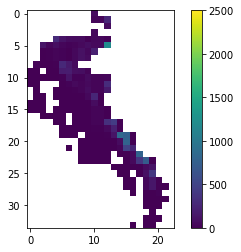

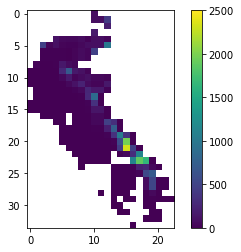

In [97]:
plt.imshow(swe0506,vmin=0, vmax=2500)
plt.colorbar()
plt.show()
plt.imshow(swe1617,vmin=0, vmax=2500)
plt.colorbar()


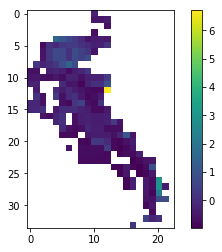

In [105]:
plt.imshow((swe0506 - swe1617) / swe1617)
plt.colorbar()

In [90]:
from osgeo import gdal
from osgeo import osr

In [99]:
# get data from df as arrays
lons = np.array(df.longitude)
lats = np.array(df.latitude)

# get the unique coordinates
uniqueLats = np.unique(lats)
uniqueLons = np.unique(lons)

# get number of columns and rows from coordinates
ncols = len(uniqueLons)    
nrows = len(uniqueLats)

# determine pixelsizes
ys = uniqueLats[1] - uniqueLats[0] 
xs = uniqueLons[1] - uniqueLons[0]

transform = (np.min(uniqueLons),xs,0,np.max(uniqueLats),0,-ys)
 
# set the coordinate system
target = osr.SpatialReference()
target.ImportFromEPSG(4326)
 
# set driver
driver = gdal.GetDriverByName('GTiff')
 
outputDataset = driver.Create("swe1617.tiff", ncols,nrows, 1,gdal.GDT_Float32)
 
# add some metadata
 
outputDataset.SetGeoTransform(transform)
outputDataset.SetProjection(target.ExportToWkt())
outputDataset.GetRasterBand(1).WriteArray(swe1617)
outputDataset.GetRasterBand(1).SetNoDataValue(np.nan)
outputDataset = None
